## Prepare the Data

### Need to prepare train/ test folders

- [reference on stackoverflow](https://stackoverflow.com/questions/53074712/how-to-split-folder-of-images-into-test-training-validation-sets-with-stratified/53585684)

### Load Data

- load pkl.gz data

```
import gzip
import pickle

with gzip.open('./data/mnist/mnist.pkl.gz', 'rb') as f: 
    (train_set, train_label), (valid_set, valid_label), (test_set, test_label) = pickle.load(f, encoding='latin1')
```

- use helper functions to download popular datasets

```
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)

mnist.keys()
```

### Split Train/ Test Data

#### Random

- use train_test_split 

    
    - use random_state to define the seed

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
df = pd.read_csv('./pd/sitka_weather_2018_full.csv')
train_set, test_set = train_test_split(df, test_size = .2, random_state = 42)

X, y = np.arange(10).reshape((5, 2)), range(5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

#### Stratified Sampling

- The attributes are important => make sure train and test sets contain the same percent 

- `split.split(df, df['TMAX_cat'])` defined split by which category col.

- use pd.cut to create category 

    - just a helper stratified col, will delete afterwards

- use the StratifiedShuffleSplit

- `Q`: how to define the label and the interval? Based on the data std or others? 

In [10]:

from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

df = pd.read_csv('./pd/sitka_weather_2018_full.csv')

df.dropna(subset = ['TMAX'], inplace = True)
df['TMAX_cat'] = pd.cut(df['TMAX'], bins = [20, 40, 60, 80], labels = [1, 2, 3])
# bins = [20, 40, 60, 80, np.inf] including all data bigger than 80
split = StratifiedShuffleSplit(n_splits = 1, test_size = .2, random_state = 42)
for train_index, test_index in split.split(df, df['TMAX_cat']): 
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
print (strat_test_set.shape)
print (strat_train_set.shape)

# check the stratified data set
strat_test_set['TMAX_cat'].value_counts()/ len(strat_test_set)

# clean the cat_ col
for set_ in (strat_train_set, strat_test_set): 
    set_.drop('TMAX_cat', axis = 1, inplace = True)

(81, 20)
(323, 20)


## Explore Data (Image Data)

### Check Image

- show 2-dimension image

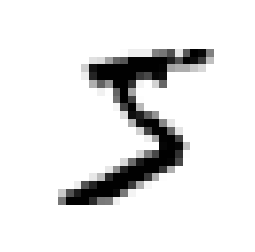

<class 'numpy.int64'>


In [5]:
# %matplotlib in line
import gzip, pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

with gzip.open('../standford_ML/pytorch/data/mnist/mnist.pkl.gz', 'rb') as f: 
    (train_set, train_label), (valid_set, valid_label), (test_set, test_label) = pickle.load(f, encoding='latin1')

some_digit = train_set[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()
print (train_label[0])

## Explore Data (not Image Data)

### Check Correlations

- use cor data: corr_matrix = df.corr()

In [12]:
import pandas as pd

df = pd.read_csv('./pd/sitka_weather_2018_full.csv')
corr_matrix = df.corr()
corr_matrix['TMAX'].sort_values(ascending = False)

TMAX    1.000000
TMIN    0.887392
WDF5    0.161351
WDF2    0.107096
PGTM    0.088166
AWND    0.020303
PRCP   -0.000737
WSF2   -0.033553
WSF5   -0.054778
SNWD         NaN
TAVG         NaN
WT01         NaN
WT02         NaN
WT04         NaN
WT05         NaN
WT08         NaN
Name: TMAX, dtype: float64

- use plot: check scatter plots between two var w/ selected col

`scatter_matrix(df[cols])`

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a2f0b70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119924be0>]], dtype=object)

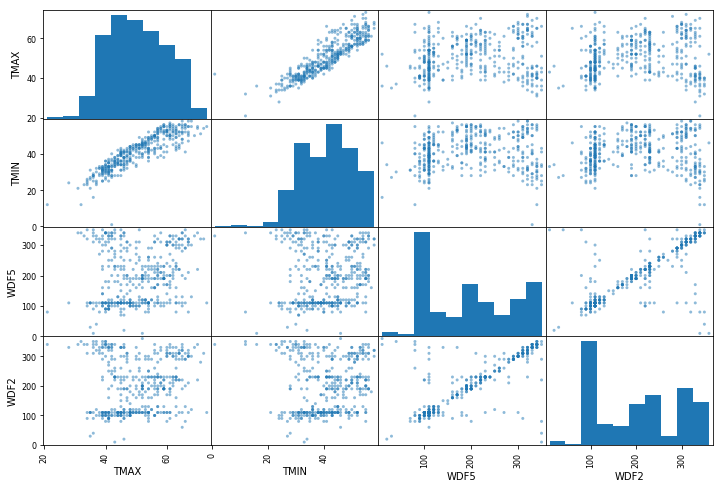

In [13]:
%matplotlib inline
from pandas.plotting import scatter_matrix
import pandas as pd

df = pd.read_csv('./pd/sitka_weather_2018_full.csv')
attri = ['TMAX', 'TMIN', 'WDF5', 'WDF2']

scatter_matrix(df[attri], figsize = (12, 8))

## Clean Data (Image)

### Scale Data to Improve the Accuracy

```
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
```

## Clean Data (not Image)

### Deal w/ NaN

- drop the row with NaN

`df.dropna(subset = ['col1'])`

- drop the whole col

`df.drop('col1', axis = 1)`

- replace the NaN w/ media value 

    - Note: the media value should be save to be used in the test test and future project set

    - use the function in pandas

        `median = df['col1'].median()`

        `df['col1'].fillna(media, inplace = True)`

    - use the function in the sklearn - SimpleImputer

        - Note: median can only be computed on numerical attributes, so need to create a copy of the data w/o the text atttibute. 

        - all the median value are stored in the imputer.statistics_

        - use the transform to implement the media to the missing value col

        - the result is numpy array and able to turn back to dataframe

        ```
        from sklearn.impute import SimpleImputer

        imputer = SimpleImputer(strategy = 'median')
        
        df_num = df.drop(['text_col1', 'text_col2'], axis = 1)

        imputer.fit(df_num)

        imputer.statistics_

        X = imputer.transform(df_num)

        df_num_tr = pd.DataFrame(X, columns = df_num.columns, index = df_num.index)

        ```

### Deal w/ Text & Category Attributes

- use OrinalEncoder for the Category text having their meaning

```
from sklearn.preprocessing import OrdinalEncoder

df_cat = df[['txt_col1']] # can have more than one category col

ordinal_encoder = OrdinalEncoder()

df_cat_encoded = ordinal_encoder.fit_transform(df_cat)

ordinal_encoder.categories_ # to check the the array


```

- use one-hot-encoding for the no ordinal col

```
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

df_cat_1hot = cat_encoder.fit_transform(df_cat) # this is SciPy sparse matrix

df_cat_1hot.toarray() # to check matrix

cat_encoder.categories_ # to check the cat name
```

### Custom Transform

- use BaseEstimator / TransformerMixin as a base class. 

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

df = pd.read_csv('./pd/sitka_weather_2018_full.csv')
num_cols = ['AWND', 'PGTM', 'PRCP', 'TMIN', 'TMAX', 'WDF2', 'WDF5'] # build a dummy X set to test the custom transform

df_X = df[num_cols]
# df_X.dropna(inplace = True)
# print (df_X.shape)
pgtm_ix, prcp_ix, tmin_ix, tmax_ix = 1, 2, 3, 4


class CombinedAttributesAdder(BaseEstimator, TransformerMixin): 
    ''' purpose of this transform is to make transformer w/ added col easier
    '''
    def __init__(self, add_prcp_per_tmin = True): 
        self.add_prcp_per_tmin = add_prcp_per_tmin
    
    def fit(self, X, y = None): 
        return self
    
    def transform(self, X, y = None): 
        pgtm_per_tmax = X[:, pgtm_ix] / X[:, tmax_ix]

        tmin_per_tmax = X[:, tmin_ix] / X[:, tmax_ix]

        if self.add_prcp_per_tmin: 
            prcp_per_tmin = X[:, prcp_ix] / X[:, tmin_ix]

            return np.c_[X, pgtm_per_tmax, tmin_per_tmax, prcp_per_tmin]
        else: 
            return np.c_[X, pgtm_per_tmax, tmin_per_tmax]
attr_adder = CombinedAttributesAdder(add_prcp_per_tmin = True)
df_X_extra_attribs = attr_adder.transform(df_X.values)
df_X_extra_attribs_fit = attr_adder.fit(df_X.values)

# print (df_X.iloc[:2, :])
# print (df_X_extra_attribs[0])
print (df_X.iloc[:2, :])

(405, 7)
    AWND   PGTM  PRCP  TMIN  TMAX   WDF2   WDF5
0  13.87   23.0  0.45  38.0  48.0  110.0  110.0
1  13.65  805.0  0.56  43.0  48.0  100.0  100.0


### Feature Scaling

### Transformation Pipeline

- for num: use the Pipeline function to combine all the function

    - deal with the Nan

    - deal with the col combination

    - deal with the feature scaler

- for others: use the Pipeline function to combine the num and the category

    - can choose the col as you wanted

    - Tip: you can specify other col as untouched by set hyperparameter to "passthrough"



In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import numpy as np

df = pd.read_csv('./pd/sitka_weather_2018_full.csv')

num_cols = ['AWND', 'PGTM', 'PRCP', 'TMIN', 'TMAX', 'WDF2', 'WDF5']
cat_cols = ['STATION', 'NAME']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), 
    ('attribs_adder', CombinedAttributesAdder()), 
    ('std_scaler', StandardScaler())
])

# # only for the num transform pipeline
# df_X = df[num_cols]
# df_X_tr = num_pipeline.fit_transform(df_X)

from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_cols), 
    ('cat', OneHotEncoder(), cat_cols)
])

test_data_pre = full_pipeline.fit_transform(df)
test_data_pre[0]




array([ 1.49233161, -1.72466734,  0.81804799, -0.33348683, -0.27725262,
       -1.04132583, -1.00092136, -1.58750083, -0.18899043,  1.03300127,
        1.        ,  1.        ])

## Train & Evaluation

### Process of Train and Evaluation

- choose one algorithm

- fit the training data

```
lin_reg = LinearRegression()

lin_reg.fit(test_data_pre, data_labels)
```

- do the prediction
```
test_data_prepare = full_pipeline.transform(test_data)

predict_data = lin_reg.predict(test_data_prepare)

```
- choose one method to evaluate. Here use the lin_mse

    - evaluate the train dataset first

    - evaluate the test dataset to check if overfit

    ```
    from sklearn.metrics import mean_squared_error

    lin_mse = mean_squared_error(labels, predict_data)

    lin_rmse = np.sqrt(lin_mse)

    ```

    - evaluate a classifier (trickier)

### Alg either for Linear Regression or Classification

- SVM (1st opt: linear SVC - for large set or plenty of features sets; 2nd opt: rbf kernel for the too large training sets)
    
    - need scaled

    `from sklearn.svm import SVC`

    - hyperparameter

        - C: alg have two conflicting obj: make the slack variable small and make the 1/2||w||2 small <- C is to define the tradeoff

        - dual: set to off unless the features > training instance

    - linear classification (following are same purpose)

        ```
        from sklearn.svm import LinearSVC
        LinearSVC(C = 1, loss = 'hinge', dual = False)

        SVC(kernel = 'linear', C = 1)
        SGDClasifier(loss = 'hinge', alpha = 1/(m * C)) # useful to handle online classification or huge datasets
        ```

        - linear situation

        ```
        svm_clf = Pipeline([
            ('scaler', StandardScaler()), 
            ('linear_svc', LinearSVC(C = 1, loss = 'hinge'))
            ])
        ```

        - non-linear situation

        ```
        polynomial_svm_clf = Pipeline([
            ('poly_features', PolynomialFeatures(degree = 3)), 
            ('scaler', StandardScaler()), 
            ('svm_clf', LinearSVC(C = 10, loss = 'hinge'))
        ])
        ```
    - linear regression (following are same purpose)

        ```
        from sklearn.svm import LinearSVR
        LinearSVR(epsilon = 1.5)
        ```

    - polynomial kernel (coef0 controls how much the model is influenced by high-degree polynomial vs low-degree polynomial. )

        - classification

            ```
            poly_kernel_svm_clf = Pipeline([
                ('scaler', StandardScaler()), 
                ('svm_clf', SVC(kernel = 'poly', degree = 3, coef0 = 1, C = 5))
            ])
            ```
        
        - regression (more regulariztion smaller C value/ epsilon value)

            ```
            from sklearn.svm import SVR

            svm_poly_reg = SVR(kernel = 'pol', degree = 2, C = 100, epsilon = .1)
            ```
    
    - Gaussian RBF kernel (overfitting reduce gamma)

        ```
        rbf_kernel_svm_clf = Pipeline([
            ('scaler', StandardScaler()), 
            ('svm_clf', SVC(kernel = 'rbf', gamma = 5, C = .001))
        ])
        ```

### Common Algorithm

- Linear regression

    - linear regression: `from sklearn.linear_model import LinearRegression`

        - get estimated parameter: `lin_reg.intercept_`; `lin_reg.coef_`

    - Decision Tree (easy to interpret -> white box models; easy overfitting without hyperparameters setting)

        `from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier`
        
        - pros: simple to understand and interpret/ easy to use/ can be used in classifiction and regression

        - cons: sensitive to training set rotation <- can be used with PCA; sensitive to small variation and Scikit-Learn is stochastic => different models with same data <- can be limited by Random Forests

        - key parameter: max_depth, and other min... max... parameter

            - tree_clf.predict_proba(新数据) 表示的是最后一个node，对应的probability，不一样的 max_depth -> 不一样的结果

        - not so key parameter: criterion (entropy & gini not so big difference)

        - increase min... hyperparameters or reduce max... hyperparamters to regularize the model by reduce its degree of freedom

        - for classification, reduce the impurity; for regression, reduce the MSE
        
    - Random Forest (black box models); (max_features; n_estimators; min_sample_leaf >=50? / max_depth; min_samplex_split; bootstrap)

        - ensemble of decision trees, trained via the bagging method. max_samples/ n_estimators set to the size of the training set. 

        `from sklearn.ensemble import RandomForestRegressor`

        - following bagging classifier is roughly equivalent to the random forest 

        `bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter = 'random', max_leaf_modes = 16), n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = -1)`
        - get all the feature importance
        
        `feature_importances_variable`

        - similar one --- Extra-Trees/ Extremely Randomized Trees

    - NN (black box models)

    - Stochastic GD

    ```
    from sklearn.linear_model import SGDRegressor
    sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = .1)
    sgd_reg.intercept_, sgd_reg.coef_
    ```



| Alg | Large m | Out-of-core support | Large n | Hyperparams | Scaling required | Scikit-Learn | 
| --- | --- | --- | --- | --- | --- | --- | 
| Normal Equation | Fast | No | Slow | 0 | No | NA | 
| SVD | Fast | No | Slow | 0 | No | LinearRegression | 
| Batch GD | Slow | No | Fast | 2 | Yes | SGDRegressor | 
| Stochastic GD | Fast | Yes | Fast | >= 2 | Yes | SGDRegressor | 
| mini-batch GD | Fast | Yes | Fast | >= 2 | Yes | SGDRegressor | 

- Non-linear Algorithm

    - transfer X data with Polynomial Features before use the linear fit

    `from sklearn.preprocessing import PolynomialFeatures`


- Regularized Linear Models 

    - Important: need to scale the data before performing the regularized models

    - Ridge Regression 

        - closed-form solution: 

            ```
            from sklearn.linear_model import Ridge
            ridge_reg = Ridge(alpha = 1, solver = 'cholesky')
            ridge_reg.fit(X,y)
            ```

        - gradient descent: 
            ```
            sgd_reg = SGDRegressor(penalty = 'l2')
            sgd_reg.fit(X, y.ravel())
            ```
    
    - Lasso Regression (Least Absolute Shrinkage and Selection Operator Regression)

        - closed-form solution: 

            ```
            from sklearn.linear_model import Lasso
            lasso_reg = Lasso(alpha = .1)
            lasso_reg.fit(X,y)
            ```

        - gradient descent: 
        
            ```
            sgd_reg = SGDRegressor(penalty = 'l1')
            ```
    - Elastic Net (middle ground between Ridge and Lasso)

        ```
        from sklearn.linear_model import ElasticNet
        elastic_net = ElasticNet(alpha = .1, l1_ratio = .5)
        # l1 = 0 == Ridge; l1 = 1 == Lasso
        elastic_net.fit(X,y)
        ```

- Classification

    - [classifier and comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

    - Binary Classifier only

        - Available Strategy

            - one-versus-the-rest (OvR)

            - one-versus-one (OvO)

        - Logistic Regression 

            - can use l1 or l2 penalties

            `from sklearn.linear_model import LogisticRegression`

        - Softmax Regression

        ```
        from sklearn.linear_model import LogisticRegression
        softmax_reg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C = 10)
        ```

        - SVM - Support Vector Machine (default use the OvO strategy)

            -  decision_function provide different scores in multi-class

            - `svm_clf.classes_` provide all the classes in the algorithm
            
            ```
            from sklearn.svm import SVC
            svm_clf = SVC()
            svm_clf.fit(X_train, y_train)

            some_digit_scores = svm_clf.decision_function([some_digit])
            ```

            - work with OneVsOneClassifier/ OneVsRestClassifier 

                - `ovr_clf.estimators_` to check ...
                ```
                from sklearn.multiclass import OneVsRestClassifier

                ovr_clf = OneVsRestClassifier(SVC())
                ovr_clf.fit(X_train, y_train)
                ovr_clf.predict([some_digit])
                ```
    
    - Multiclass Classification also O.K.
    
        - SGD (Stochastic Gradient Descent)

            - method: decision_function()
            ```
            from sklearn.linear_model import SGDClassifier

            sgd_clf = SGDClassifier(random_state = 42)
            
            y_scores = cross_val_predict(sgd_clf, train_set, train_label_5, cv = 3, method = 'decision_function')

            precisions, recalls, thresholds = precision_recall_curve(train_label_5, y_scores)
            
            ```

        - RandomForest
            
            - method:  predict_proba()
            ```
            from sklearn.ensemble import RandomForestClassifier
            forest_clf = RandomForestClassifier(random_state = 42)

            y_probas_forest = cross_val_predict(forest_clf, train_set, train_label_5, cv = 3, method = 'predict_proba')

            y_scores_forest = y_probas_forest[:, 1] # score = proba of pos class
            fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
            
            ```
        - Naive Bayes Classification

            - GaussianNB
            
            `from sklearn.naive_bayes import GaussianNB`
        
        - KNeighbors
        ```
        from sklearn.neighbors import KNeighborsClassifier
        knn_clf = KNeighborsClassifier()
        ```

- Multilabel Classification 

    - have multilabel in train_set

    ```
    y_train_large = (y_train > 7)
    y_train_odd = (y_train % == 1)
    y_multilabel = np.c_[y_train_large, y_train_odd]

    knn_clf = KNeighborsClassifier()
    knn_clf.fit(X_train, y_multilabel)
    ```
    
    - one way to evaluate w/ F1 scores for each label, then compute the average score. 

    ```
    y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
    f1_score(y_multilabel, y_train_knn_pred, average = 'macro')
    ```

    - deal w/ labels not equally important

        - give weights to different labels

        - set average = 'weighted' ??? (check scikit-learn for multilabel classifier metrics)

- Multioutput Classification (help to clean the background)

Add some noise both in the train and test image, and set the y is the clean images. 

Use the knn classification. and check the predict image again, the noise be removed. 
```
noise =  np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise =  np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
```

### Evaluation Methods During Training

- Cross-Validation - for regressor (esp. for the overfit model)

    - the score will be a list. To evalute generally, need to calculate the mean and std of the scores. 

    ```
    from sklearn.model_selection import cross_val_score

    tree_reg = DecisionTreeRegressor()

    scores = cross_val_score(tree_reg, data_prepare, data_label, scoring = 'neg_mean_squared_error', cv = 10)

    tree_rmse_scores = np.sqrt(-scores)
    ```


- Learning Curve (regressor)

    - some gap between train and val => train data is much better => overfit / Variance

        - solution: more training data
    
    - gap between train and val is small & error is not small enough => underfit / Bias

        - solution: more complex model/ more features

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y): 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2)
    train_errors, val_errors = [], []

    for m in range(1, len(X_train)): 
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth = 2, label = 'train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth = 3, label = 'val')



- Cross-Validation - for classifier    
    
    - use the cross_val_score 

    ```
    corss_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')
    ```

    - implement cross-validation by yourself

    ```
    from sklearn.model_selection import StratifiedlKFold
    from sklearn.base import clone

    sgd_clf = SGDClassifier(randome_state = 42)

    skfolds = StratifiedlKFold(n_splits = 3, random_state = 42)

    for train_index, test_index in skfolds.split(X_train, y_train_5): 
        clone_clf = clone(sgd_clf)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train_5[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train_5[test_index]
        
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)

        print(n_correct/len(y_pred))
    ```


- evaluate w/ confused matrix
    
    - for the skewed data, use recall/ precision/ F1 score to evaluate

    ```
    from sklearn.metrics import precision_score, recall_score, f1_score

    precision_score(y_train, y_pred)
    ...
    ```

    - draw precision and recall curve to check

    ```
    def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
        plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
        plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')

    # method depends on the algorithm. decision_function is for the sgd_clf
    y_scores = cross_val_predict(clf, train_set, train_label_5, cv = 3, method = 'decision_function')

    precisions, recalls, thresholds = precision_recall_curve(train_label_5, y_scores)

    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    plt.show()
    
    ```

    - Adjust the precision thresholds
    ```
    threshold_90_precision = thresholds[np.argmax(precisions >= .9)]

    y_train_pred_90 = (y_scores >= threshold_90_precision)
    print (precision_score(train_label_5, y_train_pred_90))
    print (recall_score(train_label_5, y_train_pred_90))
    ```
    
    - check PR curve (preferred because clear to see any room for the improvement) 
    ```
    def plot_precision_vs_recall(precisions, recalls):
        plt.plot(recalls, precisions, 'g-', label = 'precision vs recall')

    plot_precision_vs_recall(precisions, recalls)
    plt.show()
    ```
    - check w/ ROC curve (after PR curve)
    
    ```
    from sklearn.metrics import roc_curve

    def plot_roc_curve(fpr, tpr, label = None): 
        plt.plot(fpr, tpr, linewidth = 2, label = label)
        plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, thresholds = roc_curve(train_label_5, y_scores)
    
    plot_roc_curve(fpr, tpr)
    plt.show()
    
    ```

    - check the AUC (area under the ROC curve)

        - equal to .5 is purely random classifier

        - perfect classifier will have a ROC AUC equal to 1

        ```
        from sklearn.metrics import roc_auc_score
        roc_auc_score(y_train_5, y_scores)
        ```
    
    - save a confusion matrix for further check

        - use joblib.dump to store with pkl file 

        - use joblib.load to pick the data out

- error analysis w/ confused matrix (multi-class)

    - usually the diagonal square is the brightest

    - rows represent actual classes, while columns represent predicted classes 
    ```
    conf_mx = confusion_matrix(y_train, y_train_pred)
    plt.matshow(conf_mx, cmap = plt.cm.gray)
    plt.show()
    ```

    - to check the error more clear

        - calculate the error rate instead of absolute numbers

        - replace the diagonal with zeros, otherwise it would be too bright and to observer other errors. 

        ```
        row_sums = conf_mx.sum(axis = 1, keepdims = True)
        norm_conf_mx = conf_mx/ row_sums

        np.fill_diagonal(norm_conf_mx, 0)

        plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
        plt.show()
        ```
    

### Save Model

For future comparison, store info including: 

- hypermeter;

- trained parameters; 

- cross-validation scores; 

- predictions

```

import joblib

joblib.dump(my_model, 'my_model.sav')

my_model_loaded = joblib.load('my_model.sav')
my_model_loaded.best_params_ # depend what the model is 
```


## Fine-Tune Your Model

### Grid Search

- param_grid can add several combination

    - following example have `(3 * 4 + 2 * 3)` combination

    - each combination will have 5 times training due to the CV

- Tip: can use consecutive powers of 10 to set the hyperparameter to try out

```
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)

grid_search.fit(train_data, label)
```

- Get best parameter

`grid_search.best_params_ # to get the best parameters`

- Get best estimator

`grid_search.best_estimator_`

- Get the evaluation scores

```
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']): 

    print (np.sqrt(-mean_score), params)
```

- Note: if GridSearchCV is initialized with refit = True, it will retrain the whole training set once it finds the best estimator using cv. This is good to improve the performance by training more data. 

- Tip: can use treat some of the data preparation steps as hyperparameters. E.g. the grid search will auto find out whether or not to add a feature you were not sure about (using the add_bedrooms_per_room hyperparamter of CombinedAttributesAdder transformer. )

### Randomized Search

- similar the grid search, but just randomly choose the parameter

- can set the number of iterations


### Ensemble Methods

three methods: 

- with different algorithm (same datasets) --- voting classification

- resampling dataset as bootstrapping & permutation (same algorithm) --- bagging/ pasting --- similar bias lower variance 

- Voting Classifiers

    - vote for the higher classifiction -> voting = 'hard'

    - vote for the higher probability -> voting = 'soft' 

        - need to change parameter in the SVM 

In [15]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

X, y = datasets.make_moons(n_samples = 10000, noise = .4, random_state = 42)
# print (X.shape, y.shape, np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC() # voting = hard
svm_clf = SVC(probability = True) # voting = soft

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'soft')

for clf in (log_clf, rnd_clf, svm_clf, voting_clf): 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print (clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.8415
RandomForestClassifier 0.857
SVC 0.874
VotingClassifier 0.87


- Bagging/ Pasting

    - if using pasting, set the bootstrap = False

    - following example: train 500 decision tree; each train with 100 sample instance. The X_train of the book have 500 examples

    - use the oob_score to guess the test score. oob = out of bag, samples are not being chosen. set the oob_score = True

    - oob decision function for each training instance is vailable through `oob_decision_function_`. returns the class probabilities for each training instance. 

    - able to sampling the features by two hyperparameters: max_features and bootstrap_features

        - particularly useful with high-dimensional inputs like images.

        - Random Patches method: sampling both training instances and features. 

        - Random Subspaces method: only sampling features. 

```
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, oob_score = True)

bag_clf.fit(X_train, y_train)

bag_clf.oob_score_ # overall score
bag_clf.oob_decision_function_

y_pred = bag_clf.predict(X_test)

```

- Boosting

    - AdaBoost

        - SAMME - rely on the predictor

        ```
        from sklearn.ensemble import AdaBoostClassifier

        ada_clf = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1), n_estimators=200,
            algorithm="SAMME.R", learning_rate=0.5)
        ada_clf.fit(X_train, y_train)
        ```

        - SAMMER - rely on the probability

    - Gradient Boosting

        - gradient boosted regression trees (n_estimator control the number of trees)

        ```
        from sklearn.ensemble import GradientBoostingRegressor

        gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, learning_rate = 1.0)
        ```

        - can find the best n_estimator, need how many trees by use early stopping. 

            - use .staged_predict

            ```
            from sklearn.metrics import mean_squared_error

            X_train, X_val, y_train, y_val = train_test_split(X, y)

            gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
            gbrt.fit(X_train, y_train)

            errors = [mean_squared_error(y_val, y_pred)
                    for y_pred in gbrt.staged_predict(X_val)]
            bst_n_estimators = np.argmin(errors) + 1

            gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
            gbrt_best.fit(X_train, y_train)
            ```

            - warm_start = True, check the sample in the "Early Stopping" part

    - XGBoost check out (take care of the early stopping for the gradient boosting. )

- Stacking

## Elements to Get Best Parameter

- epoch times

- 

## Early Stopping

In [ ]:
from sklearn.base import clone

# prepare the data
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree = 90, include_bias = False)), 
    ('std_scaler', StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter = 1, tol = -np.infty, warm_start = True, penalty = None, learning_rate = 'constant', eta0 = .0005)

minimum_val_error = float('inf')
best_epoch = None
best_model = None

for epoch in range(1000): 
    sgd_reg.fit(X_train_poly_scaled, y_train) # continues wehre it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)

    if val_error < minimum_val_error: 
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)




GradientBoostingRegressor

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

## Analyze the Best Models and Their Errors

### Get parameters of the Best Models

- get feature importances

    - wendy's understanding: of the importances is the coef before the feature

```
feature_importances = grid_search.best_estimator_.feature_importances_

```

- combine the attribute names

    - for new added feature 

    `extra_attribs = ['col1', 'col2', 'col3']`

    - for cat_encoder feature

    ```
    cat_encoder = full_pipeline.named_transformers_['cat'] # which is named as cat in the full_pipeline

    cat_one_hot_attribs = list(cat_encoder.categories_[0])
    
    ```

    - for all the attribs is to add up to list

    `attributes = num_attribs + extra_attribs + cat_one_hot_attribs`

- combine these feature data with feature name

`sorted(zip(feature_importances, attributes), reverse = True)`

- can drop some col which are not so important

    - wendy's understanding: this step is to lower vector

## Evaluate Sys on the Test Set

### Try on the Test Set

- run full_pipeline to transform, NOT fit_transform, on the test Set

```
final_model = grid_search.best_estimator_

X_test = df.drop('label_col', axis = 1)
y_test = df['lable_col'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)

final_rmse = np.sqrt(final_mse)

```

- use the t-student to get the squared_error interval

```
from scipy import stats

confidence = .95

squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc = squared_errors.mean(), scale = stats.sem(squared_errors)))
```

## Dimensionality Reduction

- purpose: speed up the training; find a better solution

- warning: 

    - may make sys perform slight worse

    - make pipelines harder to maintain

    - use it, train data, then consider it. 

### Projection

### Manifold Learning

### PCA

    ```
    from sklearn.decomposition import PCA
    pca = PCA(n_components = 2)
    X2D = pca.fit_transform(X)
    ```

- explained variance ratio of each procipal component

    `pca.explained_variance_ratio_`

- number of dimentions <- choose the number of dimentions that add up to a sufficiently large portion of the variance like 95%

    `pca = PCA(n_components = .95)`

- inverse back to reconstruct data

    ```
    X_reduced = pca.fit_transform(X_train)
    X_recovered = pca.inverse_transform(X_reduced)
    ```

- different type

    - randomized PCA: set the svd_solver = 'randomized'

    - incremental PCA (for large training sets and for apply PCA online)

        ```
        from sklearn.decomposition import IncrementalPCA
        n_batches = 100
        inc_pca = IncrementalPCA(n_components = 154)
        for X_batch in np.array_split(X_train, n_batches): 
            inc_pca.partial_fit(X_batch)
        X_reduced = inc_pca.transform(X_train)
        ```

    - kernel PCA

        ```
        from sklearn.decomposition import KernelPCA
        rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = .04)
        X_reduced = rbf_pca.fit_transform(X)
        ```
    
    - tune kernel PCA

        - to get the best classification accuracy

            ```
            from sklearn.model_selection import GridSearchCV
            from sklearn.linear_model import LogisticRegression
            from sklearn.pipeline import pipeline

            clf = Pipeline([
                ('kpca', KernelPCA(n_components = 2)), 
                ('log_reg', LogisticRegression())
            ])

            param_grid = [{
                'kpca__gamma': np.linspace(.03, .05, 10), 
                'kpca__kernel': ['rbf', 'sigmoid']
            }]

            grid_search = GridSearchCV(clf, param_grid, cv = 3)
            grid_search.fit(X, y)

            print (grid_search.best_params_)
            ```

        - to yield the lowest reconstruction error

            ```
            rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = .0433, fit_inverse_transform = True)
            X_reduced = rbf_pca.fit_transform(X)
            X_preimage = rbf_pca.inverse_transform(X_reduced)

            from sklearn.metrics import mean_squared_error
            
            mean_squared_error(X, X_preimage)
            ```
    - LLE (Locally Linear Embedding)

        ```
        from sklearn.manifold import LocallyLinearEmbedding

        lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10)
        X_reduced = lle.fit_transform(X)
        ```

## Launch, Monitor, and Maintain Sys

### Get the solution ready for production

- polish the code

- write documentation and tests

### Deploy model to the preduction enviornment

- save the trained model

    - full preprocessing 

    - prediction pipeline

- load the trained model within production environment and use it to make predictions

### Update and Retrain Model Regularly

- Collect fresh data regularly and label it (e.g., using human raters). 

- Write a script to train the model and fine-tune the hyperparamters automatically. This script could run automatically per your requirement. 

- Write another script that will evalulate both the new model and the previous model on the updated test set, and deploy the model to production if the performance has not decreased. 

    - if the performance decreased, investigate it. 

    - make sure evaluate the model's input data quality. Poor-quality signal would degrade the performance. 

        - e.g. tigger an alert if more and more inputs are missing a feature. 

        - if its mean/ std drifts too far from the training set
        
        - if categorical features starts containing new categories. 
    
    - make suare keep backups of every model you create, and have the process and tools in place to roll back to a previous model quickly, in case the new model starts failing badly for some reason. 

    - keep backups of every version of your datasets so that you can roll back to a previous dataset if the new one ever gets correupted. 


## Image Error Analysis (for classification)

### Which Class w/ More Error - w/ confused matrix (multi-class)

- usually the diagonal square is the brightest

- rows represent actual classes, while columns represent predicted classes

    ```
    conf_mx = confusion_matrix(y_train, y_train_pred)
    plt.matshow(conf_mx, cmap = plt.cm.gray)
    plt.show()
    ```

- to check the error more clear

    - calculate the error rate instead of absolute numbers

    - replace the diagonal with zeros, otherwise it would be too bright and to observer other errors.
    ```
    row_sums = conf_mx.sum(axis = 1, keepdims = True)
    norm_conf_mx = conf_mx/ row_sums

    np.fill_diagonal(norm_conf_mx, 0)

    plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
    plt.show()
    ```

### Show Predict and Actual Difference

- find the combination predict correct/ error images 

- show them

- example is to show 3 and 5 physically to find why mixed
```
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8, 8))
plt.subplt(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplt(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplt(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplt(224); plot_digits(X_bb[:25], images_per_row = 5)

plt.show()
```

## Add Log File

- save the error messages

- save the run time duration

In [ ]:
import logging
from datetime import datetime

startTime = datetime.now()
LOG_FILENAME = 'logging_example.out'

logging.basicConfig(
    filename=LOG_FILENAME,
    level=logging.INFO,
    format='%(asctime)s %(message)s', 
    datefmt='%d/%m/%Y %H:%M:%S'
)

module_logger = logging.getLogger(LOG_FILENAME)

new_logging_area ='=' * 10
module_logger.info(new_logging_area)

try:
    # run the normal script
    print (a)

except:
    # record any error message may occur
    logging.exception("message")

finally:
    # record the running duration no matter any issue occurred
    dur = datetime.now() - startTime
    
    # it's like a period of time, in days / seconds / microseconds
    dur_info = 'SCRIPT DURATION: {} seconds'.format(dur.seconds)
    dur_info = 'SCRIPT DURATION: {} minutes'.format(dur.seconds/60.0)
    
    module_logger.info(dur_info)
    module_logger.info(new_logging_area)

In [ ]:
import logging
from datetime import datetime
startTime = datetime.now()
LOG_FILENAME = 'logging_example.out'


logging.basicConfig(
    filename=LOG_FILENAME,
    level=logging.INFO,
    format='%(asctime)s %(message)s', 
    datefmt='%d/%m/%Y %H:%M:%S'
)

module_logger = logging.getLogger('logging_example.out')

try:
    print ('a')
except:
    # print (dur)
    
    logging.exception("message")

finally:
    new_logging_area ='=' * 10
    dur = datetime.now() - startTime
    # it's like a period of time, in days / seconds / microseconds
    dur_info = 'SCRIPT DURATION: {} seconds'.format(dur.seconds)
    dur_info = 'SCRIPT DURATION: {} minutes'.format(dur.seconds/60.0)
    module_logger.info(new_logging_area)
    module_logger.info(dur_info)
    module_logger.info(new_logging_area)